In [1]:
#os.chdir('/home/lichi/jupiter/imaginarium')
import pandas as pd
import numpy as np
import pickle
import os
from random import sample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline

from lib.gumbel_softmax import gumbel_softmax
from lib.data_preprocessing import get_training_data, pca_transfrom

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

Populating the interactive namespace from numpy and matplotlib


/home/lichi/venv/python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
logits = torch.FloatTensor([[0.2, 0.8, 0.]])
#gumbel_softmax(logits)

In [3]:
gumbel_softmax(logits, tau=0.99, hard=True, eps=1e-10)

tensor([[0., 0., 1.]])

#### Загружаем данные

In [4]:
with open('preprocessed_data/words_coco_vectors.pickle', 'rb') as f:
    words_vec = pickle.load(f, encoding='latin1')
with open('preprocessed_data/image_coco_vectors.pickle', 'rb') as f:
    img_vec = pickle.load( f, encoding='latin1')

#### Бьем на трейн и тест

In [5]:
words_vec_train = words_vec
words_vec_test = words_vec
img_vec_train = img_vec[:150,:]
img_vec_test = img_vec[150:,:]

### Делаем модель

In [17]:
# Датасет - подготавливаем наборы из 10 картинок , выбираем из них случайно одну
params = {
    'num_samples': 500,
    'num_cards': 5,
    'num_words': 998,
    'len_emb': 20,
    'len_dense': 20,
    'num_players':2
}

words_vec_train_pca, img_vec_train_pca, words_vec_test_pca, img_vec_test_pca  = pca_transfrom(
    words_vec_train, img_vec_train, words_vec_test, img_vec_test, n_components = params['len_emb'])


### Учим модель

In [18]:
model = ImaginariumModel(params).to(device)
loss_fn = torch.nn.NLLLoss().to(device)
accuracy_list, loss_list = [], []


num_batches = 1000
end_lr = 1.0
factor = 1000
step_size = 10

for t in range(num_batches):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=1)
    
    clr = cyclical_lr(step_size, min_lr = end_lr / factor, max_lr = end_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
    
    X_img, y_what_card_leader_choose, X_txt, X_img_ind = get_training_data(
        params, img_vec_train_pca, words_vec_train_pca
    )
    y_which_players_leader = torch.LongTensor([np.random.randint(
        0,params['num_players']) for x in range(params['num_samples'])
                             ])
    
    y_pred = model(
        X_img, X_txt, y_which_players_leader, y_what_card_leader_choose
    )
    
    y_pred_ind = np.argmax(
        y_pred.detach().numpy(),
        axis = 1
    )
    
    if params['num_players'] < 3:
        target = np.argmax(y_what_card_leader_choose, axis = 1)
    else:
        target = y_which_players_leader
    
    accuracy = np.mean([x == y for x,y
                    in zip(y_pred_ind, target)])
    accuracy_list.append(accuracy)
    
    loss = loss_fn(y_pred, target)
    loss_list.append(loss.item())
    if t % 10. == 0:
        print('\n new_model, batch = {0}, loss = {1}, acc = {3}, probs = {2}'.format(
            t, round(mean(loss_list[-5:]),5), str(y_pred[0,:].tolist()), mean(accuracy_list[-5:])))
    optimizer.zero_grad()
    loss.backward()
    #scheduler.step()
    optimizer.step()
    


 new_model, batch = 0, loss = -0.20489, acc = 0.276, probs = [0.20303097367286682, 0.2113690972328186, 0.1776033192873001, 0.19668729603290558, 0.21130932867527008]

 new_model, batch = 10, loss = -0.20388, acc = 0.2684, probs = [0.19750869274139404, 0.1752653867006302, 0.19953346252441406, 0.21284928917884827, 0.21484321355819702]

 new_model, batch = 20, loss = -0.2044, acc = 0.2772, probs = [0.17601805925369263, 0.21218344569206238, 0.19939960539340973, 0.20176571607589722, 0.21063314378261566]

 new_model, batch = 30, loss = -0.20399, acc = 0.2812, probs = [0.19056911766529083, 0.20984438061714172, 0.18617482483386993, 0.2095945030450821, 0.2038172036409378]

 new_model, batch = 40, loss = -0.20404, acc = 0.2776, probs = [0.19996197521686554, 0.19236449897289276, 0.20062267780303955, 0.21668675541877747, 0.19036412239074707]

 new_model, batch = 50, loss = -0.20393, acc = 0.2712, probs = [0.18557198345661163, 0.22047512233257294, 0.1904531717300415, 0.22739054262638092, 0.17610919

KeyboardInterrupt: 

### Класс новый

In [14]:
class ImaginariumModel(torch.nn.Module):
    def __init__(self, params, inference = False, categorical = False):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ImaginariumModel, self).__init__()
        self._params = params
        
        self._linear10 = torch.nn.Linear(params['len_emb'], params['len_dense'])
        self._linear11 = torch.nn.Linear(params['len_emb'], params['len_dense'])
        self._linear12 = torch.nn.Linear(params['len_emb'], params['len_dense'])
        self._linear13 = torch.nn.Linear(params['len_emb'], params['len_dense'])
        self._linear2 = torch.nn.Linear(params['num_cards'], params['num_cards'])
        self._distance0axis = torch.nn.modules.distance.CosineSimilarity(dim = 0)
        self._distance1axis = torch.nn.modules.distance.CosineSimilarity(dim = 1)
        self._distance2axis = torch.nn.modules.distance.CosineSimilarity(dim = 2)
        self._distance3axis = torch.nn.modules.distance.CosineSimilarity(dim = 3)
        self._softmax = torch.nn.Softmax()
        self._softmax1dim = torch.nn.Softmax(dim=1)
        self._softmax2dim = torch.nn.Softmax(dim=2)
        self._relu = torch.nn.ReLU()
        self._combination = nn.Sequential(self._linear10, self._softmax1dim, self._linear12)
        self._combination2 = nn.Sequential(self._linear11, self._relu, self._linear13)
        self._inference = inference
        self._categorical = categorical
        
    def plus_images(self, X_all, X_leader, final_words, index_chose_img):
        final_words_repeat = final_words.repeat(params['num_cards'],1,1).permute(1,0,2)
        final_words_loss_repeat = final_words.repeat(
            params['num_players'],1,1
        ).permute(1,0,2)
        final_words_weights_images = final_words.repeat(
            params['num_cards'],1,1
        ).permute(1,0,2).repeat(
            params['num_players'],1,1,1
        )
        # Считаем расстояние от каждой картинки до слова лидера
        weights_images = (
            self._distance3axis(
                X_all, final_words_weights_images
            )
        )

        weights_images = self._softmax2dim(weights_images)

        # Получаем по картинке для каждого игрока и ведущего
        final_images = torch.mul(weights_images,
                                 X_all.permute(3,0,1,2)).permute(1,2,3,0).sum(dim = 2)
        ### Выбираем между ними и картинкой ведущего
        X_leader_true = torch.stack([X_leader[num,ind,:]
                                     for num,ind in enumerate(index_chose_img)]).unsqueeze(0)
        #all_final_images = torch.cat((X_leader_true, final_images))
        all_final_images = final_images
        
        ### Опять считаем расстояния (от размноженных на 3 игрока слов
        
        distance_works_leader_images_players = self._distance2axis(
            final_words_loss_repeat.permute(1,0,2), all_final_images
        )
        return self._softmax1dim(
            distance_works_leader_images_players.permute(1,0)
        )

    def forward(self, x_img, x_txt, y_which_players_leader, y_what_card_leader_choose):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        
        if not self._inference:
            x_img_dense = self._linear10(x_img)
            x_txt_dense = x_txt
        else:
            x_img_dense = x_img
            x_txt_dense = x_txt
            
        if params['num_players']<3:
            x_leader_dense = x_img_dense
        else:
            x_leader_dense = torch.stack([x_img_dense[ind,i,:,:]
                                      for i,ind in enumerate(y_which_players_leader)])

        ### Делаем наиболее подходящие картинки
        index_chose_img = torch.argmax(y_what_card_leader_choose, dim=1)
        output = [x_leader_dense[num,ind,:].repeat(self._params['num_words'],1)
                  for num,ind in enumerate(index_chose_img)]
        x_leader_dense_repeat = torch.stack(output, 0)
        logits = self._distance2axis(x_leader_dense_repeat, x_txt_dense)
        weights_words = self._softmax(logits)
        #weights_words = gumbel_softmax(logits, hard = False, eps=1e-10)
        
        final_words = torch.mul(weights_words, x_txt_dense.permute(2,0,1)).permute(1,2,0).sum(dim = 1)
        
        if params['num_players']<3:
            final_words_repeat = final_words.repeat(params['num_cards'],1,1).permute(1,0,2)
            logits = self._distance2axis(
                    final_words_repeat, x_leader_dense
                )
            return self._softmax(logits)
        

        distance_works_leader_images_players = self.plus_images(x_img_dense, x_leader_dense,
                                              final_words, index_chose_img)
        return distance_works_leader_images_players



### Бейзлайн

In [61]:
def count_baseline_results(params):
    X_img, y_what_card_leader_choose, X_txt, X_img_ind = get_training_data(
    params, img_vec_test_pca, words_vec_test_pca
    )
    y_which_players_leader = torch.LongTensor([np.random.randint(
        0,params['num_players']) for x in range(params['num_samples'])
                             ])

    model_base = ImaginariumModel(params, inference = True, categorical = False).to(device)

    y_pred = model_base(
            X_img, X_txt, y_which_players_leader, y_what_card_leader_choose
        )
    y_pred_ind = np.argmax(
        y_pred.detach().numpy(),
        axis = 1
    )
    accuracy_baseline = np.mean([x==y for x,y
                    in zip(y_pred_ind, y_which_players_leader)])
    return accuracy_baseline
    


In [128]:
len_emb_list = [2,3,4,5,10, 15, 20, 50, 100, 150, 200, 250, 500, 900, 1000, 1024, 1023]
accuracy_list_baseline = []
for len_emb in len_emb_list:
    params = {
        'num_samples': 2000,
        'num_cards': 5,
        'num_words': 998,
        'len_emb': len_emb,
        'len_dense': 50,
        'num_players':5,
    }
    
    words_vec_train_pca, img_vec_train_pca, words_vec_test_pca, img_vec_test_pca  = pca_transfrom(
        words_vec_train, img_vec_train, words_vec_test, img_vec_test, n_components = params['len_emb'])
    accuracy_list_baseline.append(count_baseline_results(params))

/home/lichi/venv/python3/lib/python3.5/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/lichi/venv/python3/lib/python3.5/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/lichi/venv/python3/lib/python3.5/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/lichi/venv/python3/lib/python3.5/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

No handles with labels found to put in legend.


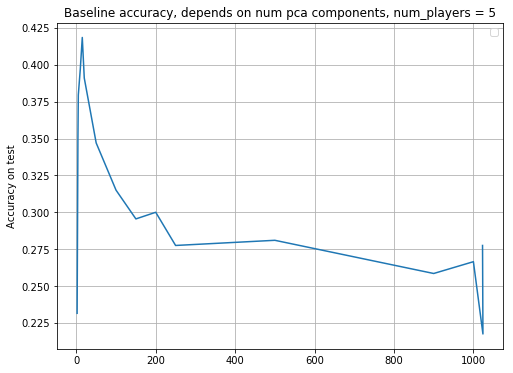

In [57]:
N = len(len_emb_list)
folder = 'N_players/cooperative'
title = 'Baseline accuracy, depends on num pca components, num_players = {0}'.format(params['num_players'])
fig = plt.plot(len_emb_list[:N], accuracy_list_baseline[:N])
plt.ylabel('Accuracy on test')
plt.title(title)
plt.legend()
savefig('pictures/{0}/{1}.png'.format(folder, title))

# Рисуем графики

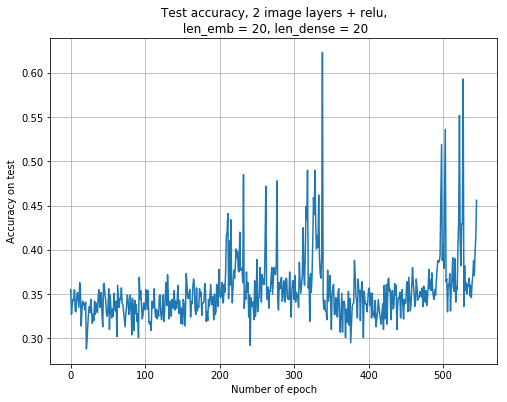

In [192]:
mean_acc = accuracy_list
title = 'Test accuracy, 2 image layers + relu,\n len_emb = {0}, len_dense = {1}'.format(
    params['len_emb'], params['len_dense'])
folder = 'N_players/cooperative'
fig = plt.plot(list(range( len(mean_acc))), mean_acc, label = 'model')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy on test')
plt.title(title)
savefig('pictures/{0}/{1}.png'.format(folder, title))

#### Функция, которая берет тестовую и тренировочную выборку

In [ ]:
def probs_metrics_test_train(model, params, img_vec_pca, words_vec_pca):
    X_img, y_what_card_leader_choose, X_txt, X_img_ind = get_training_data(
        params, img_vec_pca, words_vec_pca
    )
    y_which_players_leader = torch.LongTensor([np.random.randint(
        0,params['num_players']) for x in range(params['num_samples'])
                             ])
    y_pred = model(
        X_img, X_txt, y_which_players_leader, y_what_card_leader_choose
    )
    y_pred_ind = np.argmax(
        y_pred.detach().numpy(),
        axis = 1
    )
    return (y_pred, y_which_players_leader, np.mean([x==y for x,y
                    in zip(y_pred_ind, y_which_players_leader)]))

### Логирование в tensorboard

In [ ]:
from tensorboardX import SummaryWriter
tensorboard = SummaryWriter('runs')


x = np.arange(1,101)
y = 20 + 3 * x + np.random.random(100) * 100

# Log simple values
for i in range(0,100):
    tensorboard.add_scalar('value', y[i], i)

# Log images 
#img = skimage.io.imread(r'C:\Users\212551241\Downloads\example_img.jpg')
#tensorboard.add_image('example_image', img, 0)

# Log plots
fig = plt.figure()
plt.plot(x, y, 'o')
plt.close()
tensorboard.add_figure('example_plot', fig, 0)

# Log histograms
rng = np.random.RandomState(10)
a = np.hstack((rng.normal(size=1000), rng.normal(loc=5, scale=2, size=1000)))
tensorboard.add_histogram('example_hist', a, 0, 'auto')

tensorboard.close()

### Дебажим

In [10]:
def cyclical_lr(stepsize, min_lr=3e-2, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

### Шапка для картинок

In [12]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Ubuntu'
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
# чтобы был русский шрифт
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)


Populating the interactive namespace from numpy and matplotlib


/home/lichi/venv/python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
